=== Démo du Modem QAM ===

--- Tableau de correspondance ---
Décimal | Bits | I | Q | Énergie (kW) | Phase (°)
--------------------------------------------------
      0 | 0000 |   0.0 |   0.0 |    0.000000 |      0.00
      1 | 0001 |   0.0 |   1.0 |    0.001000 |     90.00
      2 | 0010 |   0.0 |   3.0 |    0.009000 |     90.00
      3 | 0011 |   0.0 |   2.0 |    0.004000 |     90.00
      4 | 0100 |   1.0 |   3.0 |    0.010000 |     71.57
      5 | 0101 |   1.0 |   2.0 |    0.005000 |     63.43
      6 | 0110 |   1.0 |   0.0 |    0.001000 |      0.00
      7 | 0111 |   1.0 |   1.0 |    0.002000 |     45.00
      8 | 1000 |   3.0 |   3.0 |    0.018000 |     45.00
      9 | 1001 |   3.0 |   2.0 |    0.013000 |     33.69
     10 | 1010 |   3.0 |   0.0 |    0.009000 |      0.00
     11 | 1011 |   3.0 |   1.0 |    0.010000 |     18.43
     12 | 1100 |   2.0 |   0.0 |    0.004000 |      0.00
     13 | 1101 |   2.0 |   1.0 |    0.005000 |     26.57
     14 | 1110 |   2.0 |   3.0 |    0.01

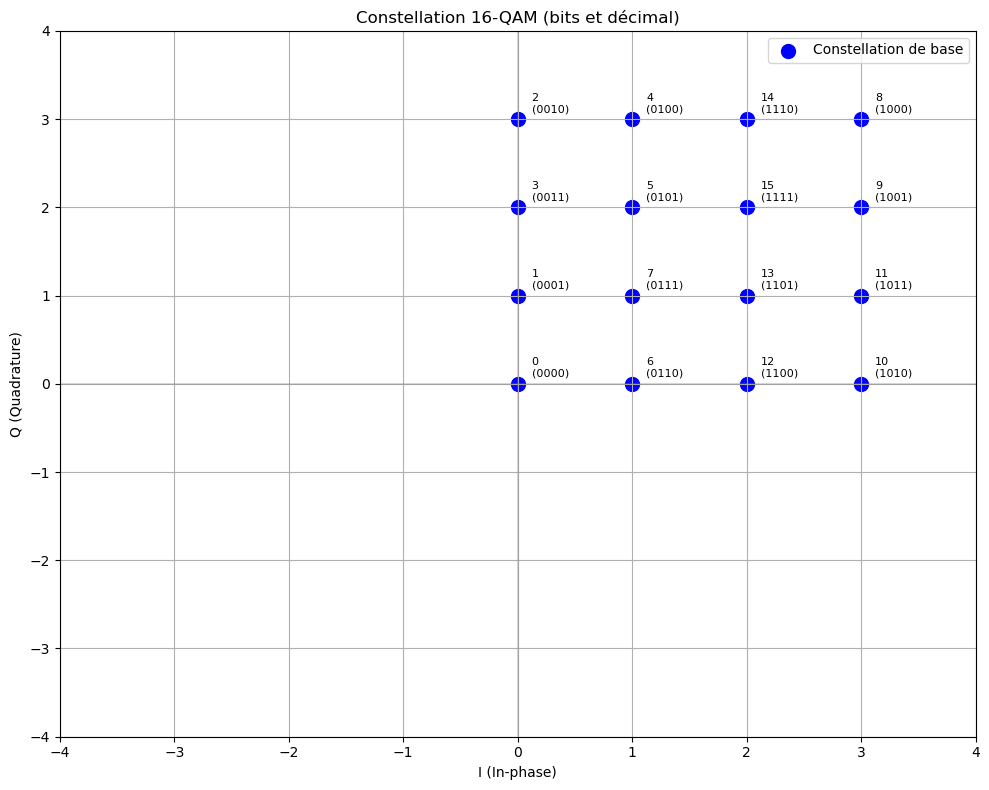


Transmission de 1000 bits aléatoires
Taux d'erreur binaire (BER): 0.096000


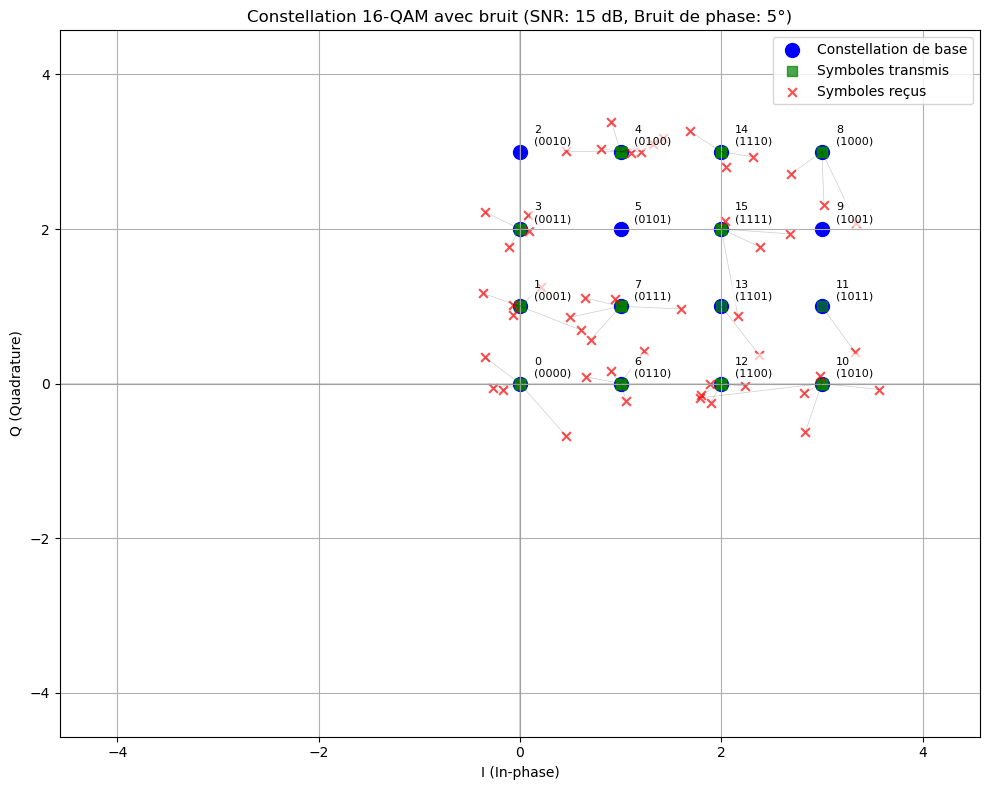

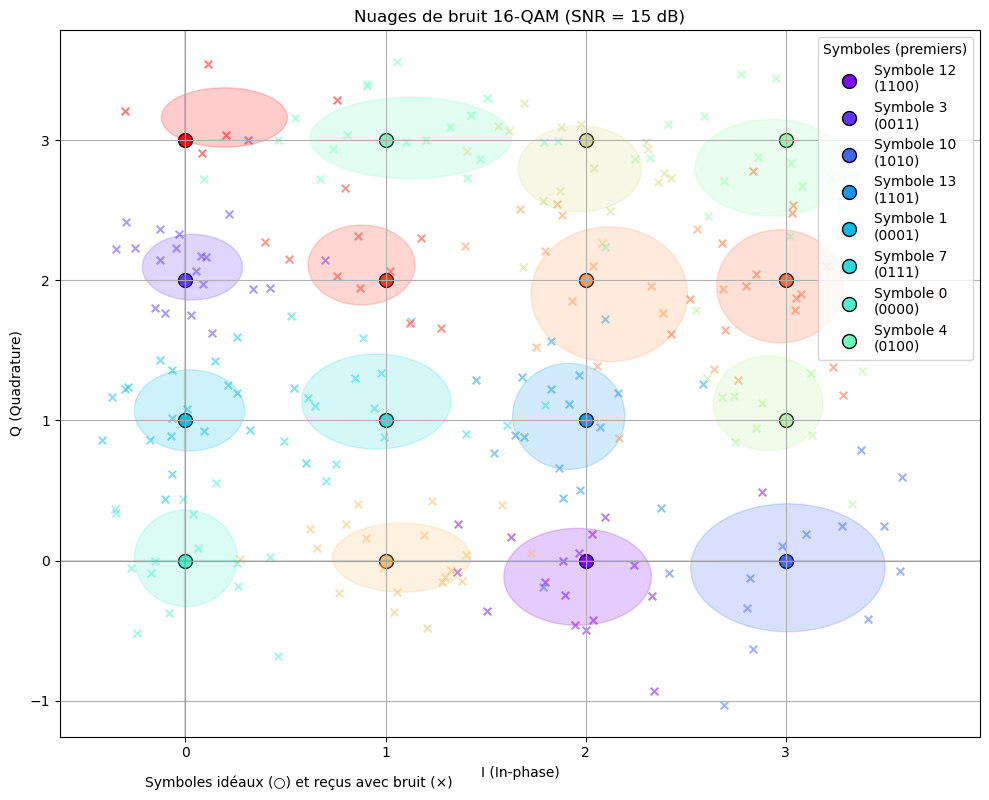


Analyse du BER en fonction du SNR...


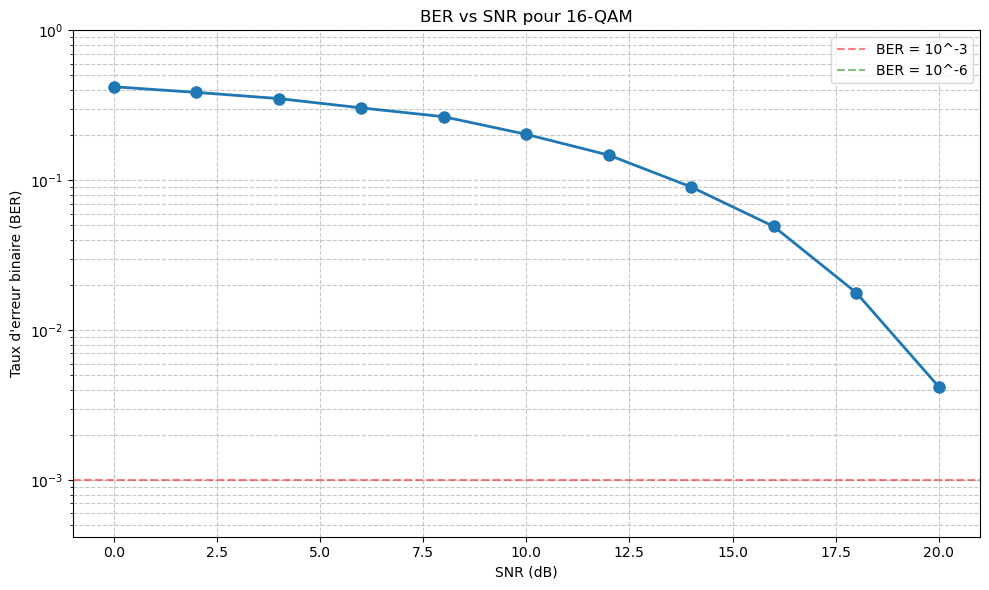


Application à la transmission d'une image...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from PIL import Image
import os

class QAMModem:
    def __init__(self, M=16, use_gray_code=False, first_symbol_position=0):
        """
        Initialisation du modem QAM
        
        Paramètres:
        -----------
        M : int
            Ordre de modulation (par défaut 16-QAM)
        use_gray_code : bool
            Utiliser le code Gray pour la modulation (par défaut False)
        first_symbol_position : int
            Position du premier symbole (0: premier quadrant, 1-3: autres quadrants)
        """
        self.M = M
        self.k = int(np.log2(M))
        self.sqrt_M = int(np.sqrt(M))
        self.use_gray_code = use_gray_code
        self.first_symbol_position = first_symbol_position % 4
        
        self.create_symbol_mapping()
        self.correspondence_table = self.generate_correspondence_table()
       
    def gray_encode(self, n):
        """Encode un nombre en code Gray"""
        return n ^ (n >> 1)
    
    def gray_decode(self, n):
        """Decode un nombre en code Gray"""
        m = n
        while m:
            m >>= 1
            n ^= m
        return n
    
    def create_symbol_mapping(self):
        """Crée le mapping des symboles selon l'ordre de modulation et le code Gray"""
        self.bit_to_symbol = {}
        self.symbol_to_bit = {}
        
        base_positions = []
        for i in range(self.sqrt_M):
            for q in range(self.sqrt_M):
                base_positions.append((i, q))
        
        adjusted_positions = []
        for i, q in base_positions:
            if self.first_symbol_position == 0:
                adjusted_i, adjusted_q = i, q
            elif self.first_symbol_position == 1:
                adjusted_i, adjusted_q = -i, q
            elif self.first_symbol_position == 2:
                adjusted_i, adjusted_q = -i, -q
            elif self.first_symbol_position == 3:
                adjusted_i, adjusted_q = i, -q
                
            adjusted_positions.append((adjusted_i, adjusted_q))
            
        for idx in range(self.M):
            if self.use_gray_code:
                bit_idx = self.gray_encode(idx)
            else:
                bit_idx = idx
            
            bits = [int(b) for b in format(bit_idx, f'0{self.k}b')]
            bit_tuple = tuple(bits)
            
            i, q = adjusted_positions[idx]
            symbol = complex(i, q)
            
            self.bit_to_symbol[bit_tuple] = symbol
            self.symbol_to_bit[symbol] = bit_tuple
    
    def generate_correspondence_table(self):
        """Génère le tableau de correspondance des symboles"""
        table = []
        for symbol, bits in self.symbol_to_bit.items():
            i = symbol.real
            q = symbol.imag
            energy = abs(symbol) ** 2 / 1000  # Conversion en kW
            phase = np.angle(symbol, deg=True)
            decimal = int(''.join(str(b) for b in bits), 2)
            
            table.append({
                'symbol': symbol,
                'bits': bits,
                'decimal': decimal,
                'I': i,
                'Q': q,
                'energy': energy,
                'phase': phase
            })
        
        return sorted(table, key=lambda x: x['decimal'])
    
    

    def print_correspondence_table(self):
        """Affiche le tableau de correspondance"""
        print("\n--- Tableau de correspondance ---")
        print("Décimal | Bits | I | Q | Énergie (kW) | Phase (°)")
        print("-" * 50)
        
        for entry in self.correspondence_table:
            bits_str = ''.join(str(b) for b in entry['bits'])
            print(f"{entry['decimal']:7d} | {bits_str:>{self.k}} | {entry['I']:5.1f} | {entry['Q']:5.1f} | {entry['energy']:11.6f} | {entry['phase']:9.2f}")
    

    def print_energy_phase_summary(self):
        """Affiche le bilan des énergies et des phases"""
        energy_summary, phase_summary = self.calculate_energy_phase_summary()
        
        print("\n--- Bilan des énergies ---")
        print(f"Énergie minimale: {energy_summary['min']:.6f} kW")
        print(f"Énergie maximale: {energy_summary['max']:.6f} kW")
        print(f"Énergie moyenne: {energy_summary['mean']:.6f} kW")
        print(f"Écart-type énergie: {energy_summary['std']:.6f} kW")
        print(f"Énergie totale: {energy_summary['total']:.6f} kW")
        
        print("\n--- Bilan des phases ---")
        print(f"Phase minimale: {phase_summary['min']:.2f}°")
        print(f"Phase maximale: {phase_summary['max']:.2f}°")
        print(f"Phase moyenne: {phase_summary['mean']:.2f}°")
        print(f"Écart-type phase: {phase_summary['std']:.2f}°")

    def calculate_energy_phase_summary(self):
        """Calcule le bilan des énergies et des phases"""
        energies = [entry['energy'] for entry in self.correspondence_table]
        phases = [entry['phase'] for entry in self.correspondence_table]
        
        energy_summary = {
            'min': min(energies),
            'max': max(energies),
            'mean': np.mean(energies),
            'std': np.std(energies),
            'total': sum(energies)
        }
        
        phase_summary = {
            'min': min(phases),
            'max': max(phases),
            'mean': np.mean(phases),
            'std': np.std(phases)
        }
        
        return energy_summary, phase_summary

    def modulate(self, bits):
        """Module une séquence de bits en symboles QAM"""
        if len(bits) % self.k != 0:
            padding = self.k - (len(bits) % self.k)
            bits = np.pad(bits, (0, padding), 'constant')
        
        symbols = []
        for i in range(0, len(bits), self.k):
            bit_group = tuple(bits[i:i+self.k])
            symbols.append(self.bit_to_symbol[bit_group])
        
        return np.array(symbols)
    
    def demodulate(self, received_symbols):
        """Démodule des symboles QAM en bits"""
        bits = []
        
        for symbol in received_symbols:
            distances = [abs(symbol - s) for s in self.symbol_to_bit.keys()]
            nearest_symbol = list(self.symbol_to_bit.keys())[np.argmin(distances)]
            bit_group = self.symbol_to_bit[nearest_symbol]
            bits.extend(bit_group)
            
        return np.array(bits, dtype=int)
    
    def add_noise(self, symbols, snr_db, phase_noise_deg=0):
        """Ajoute du bruit AWGN et du bruit de phase aux symboles"""
        signal_power = np.mean(np.abs(symbols) ** 2)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        
        noise = np.sqrt(noise_power / 2) * (np.random.randn(len(symbols)) + 1j * np.random.randn(len(symbols)))
        
        if phase_noise_deg > 0:
            phase_noise_rad = np.deg2rad(np.random.normal(0, phase_noise_deg, len(symbols)))
            phase_noise_factor = np.exp(1j * phase_noise_rad)
            symbols = symbols * phase_noise_factor
        
        noisy_symbols = symbols + noise
        
        return noisy_symbols, noise
    
    def calculate_ber(self, original_bits, demodulated_bits):
        """Calcule le taux d'erreur binaire (BER)"""
        min_len = min(len(original_bits), len(demodulated_bits))
        original_bits = original_bits[:min_len]
        demodulated_bits = demodulated_bits[:min_len]
        
        errors = np.sum(original_bits != demodulated_bits)
        ber = errors / min_len
        
        return ber
    
    def analyze_ber_vs_snr(self, snr_range, num_bits=10000, phase_noise_deg=0):
        """Analyse le BER en fonction du SNR"""
        ber_results = []
        bits = np.random.randint(0, 2, num_bits)
        
        for snr in snr_range:
            symbols = self.modulate(bits)
            noisy_symbols, _ = self.add_noise(symbols, snr, phase_noise_deg)
            demodulated_bits = self.demodulate(noisy_symbols)
            ber = self.calculate_ber(bits, demodulated_bits)
            ber_results.append(ber)
            
        return np.array(ber_results)
    
    def plot_constellation(self, symbols=None, noisy_symbols=None, snr_db=None, 
                         phase_noise_deg=0, title="Constellation QAM"):
        """Affiche la constellation QAM avec bits ET décimal"""
        plt.figure(figsize=(10, 8))
        
        constellation_symbols = np.array(list(self.symbol_to_bit.keys()))
        plt.scatter(constellation_symbols.real, constellation_symbols.imag, 
                  color='blue', marker='o', s=100, label="Constellation de base")
        
        for symbol, bits in self.symbol_to_bit.items():
            decimal = int(''.join(str(b) for b in bits), 2)
            bit_str = ''.join(str(b) for b in bits)
            label = f"{decimal}\n({bit_str})"
            
            offset_x = 10 if symbol.real >= 0 else -40
            offset_y = 5 if symbol.imag >= 0 else -25
            
            plt.annotate(label, (symbol.real, symbol.imag),
                         xytext=(offset_x, offset_y), 
                         textcoords='offset points',
                         fontsize=8,
                         ha='left',
                         bbox=dict(boxstyle='round,pad=0.3', 
                                  fc='white', alpha=0.7,
                                  edgecolor='none'))

        if symbols is not None:
            plt.scatter(symbols.real, symbols.imag, color='green', marker='s', s=60, 
                      alpha=0.7, label="Symboles transmis")
        
        if noisy_symbols is not None:
            plt.scatter(noisy_symbols.real, noisy_symbols.imag, color='red', marker='x', s=40, 
                      alpha=0.7, label="Symboles reçus")
            
            if symbols is not None and len(symbols) == len(noisy_symbols):
                for orig, noisy in zip(symbols, noisy_symbols):
                    plt.plot([orig.real, noisy.real], [orig.imag, noisy.imag], 
                           'k-', alpha=0.2, linewidth=0.5)
        
        full_title = title
        if snr_db is not None:
            full_title += f" (SNR: {snr_db} dB"
            if phase_noise_deg > 0:
                full_title += f", Bruit de phase: {phase_noise_deg}°"
            full_title += ")"
        
        plt.title(full_title)
        plt.xlabel("I (In-phase)")
        plt.ylabel("Q (Quadrature)")
        plt.grid(True)
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
        plt.legend()
        
        margin = 1
        max_val = max(abs(constellation_symbols.real.max()), abs(constellation_symbols.imag.max()))
        if noisy_symbols is not None:
            max_val = max(max_val, abs(noisy_symbols.real.max()), abs(noisy_symbols.imag.max()))
        
        plt.xlim(-max_val-margin, max_val+margin)
        plt.ylim(-max_val-margin, max_val+margin)
        
        plt.tight_layout()
        plt.show()
    
    def plot_noise_cloud(self, transmitted_symbols, received_symbols, snr_db, title="Nuages de bruit QAM"):
        """Affiche les nuages de bruit autour de chaque symbole"""
        plt.figure(figsize=(10, 8))
        
        symbol_groups = {}
        for tx_sym, rx_sym in zip(transmitted_symbols, received_symbols):
            distances = [abs(tx_sym - s) for s in self.symbol_to_bit.keys()]
            nearest_symbol = list(self.symbol_to_bit.keys())[np.argmin(distances)]
            
            if nearest_symbol not in symbol_groups:
                symbol_groups[nearest_symbol] = []
            symbol_groups[nearest_symbol].append(rx_sym)
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(symbol_groups)))
        
        for i, (symbol, color) in enumerate(zip(symbol_groups.keys(), colors)):
            decimal = int(''.join(str(b) for b in self.symbol_to_bit[symbol]), 2)
            bit_str = ''.join(str(b) for b in self.symbol_to_bit[symbol])
            label = f"Symbole {decimal}\n({bit_str})"
            
            plt.scatter([symbol.real], [symbol.imag], s=100, color=color, marker='o', 
                      edgecolors='black', label=label)
            
            rx_syms = np.array(symbol_groups[symbol])
            plt.scatter(rx_syms.real, rx_syms.imag, s=30, color=color, alpha=0.5, marker='x')
            
            if len(rx_syms) > 5:
                std_real = np.std(rx_syms.real)
                std_imag = np.std(rx_syms.imag)
                mean_real = np.mean(rx_syms.real)
                mean_imag = np.mean(rx_syms.imag)
                
                ellipse = Ellipse(
                    (mean_real, mean_imag), 
                    width=2*std_real, height=2*std_imag,
                    alpha=0.2, color=color
                )
                plt.gca().add_patch(ellipse)
        
        plt.title(f"{title} (SNR = {snr_db} dB)")
        plt.xlabel("I (In-phase)")
        plt.ylabel("Q (Quadrature)")
        plt.grid(True)
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        if len(handles) > 8:
            plt.legend(handles[:8], labels[:8], loc="upper right", title="Symboles (premiers)")
            plt.figtext(0.15, 0.01, "Symboles idéaux (○) et reçus avec bruit (×)", ha='left')
        else:
            plt.legend(loc="best")
        
        plt.tight_layout()
        plt.show()
    
    def plot_ber_vs_snr(self, snr_range, ber_values, title="BER en fonction du SNR"):
        """Affiche le graphique du BER en fonction du SNR"""
        plt.figure(figsize=(10, 6))
        
        plt.semilogy(snr_range, ber_values, 'o-', linewidth=2, markersize=8)
        
        plt.title(title)
        plt.xlabel("SNR (dB)")
        plt.ylabel("Taux d'erreur binaire (BER)")
        plt.grid(True, which="both", linestyle='--', alpha=0.7)
        
        plt.axhline(y=1e-3, color='r', linestyle='--', alpha=0.5, label="BER = 10^-3")
        plt.axhline(y=1e-6, color='g', linestyle='--', alpha=0.5, label="BER = 10^-6")
        
        plt.ylim(1e-7 if min(ber_values) < 1e-6 else min(ber_values)/10, 1)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def transmit_image(self, image_path, snr_db=20, phase_noise_deg=0, show_images=True):
        """Applique le modem QAM à la transmission d'une image"""
        try:
            img = Image.open(image_path).convert('L')
            img_array = np.array(img)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image: {e}")
            return None, None, None
        
        flat_pixels = img_array.flatten()
        bits = np.unpackbits(flat_pixels.astype(np.uint8).reshape(-1, 1), axis=1).flatten()
        
        symbols = self.modulate(bits)
        noisy_symbols, _ = self.add_noise(symbols, snr_db, phase_noise_deg)
        demodulated_bits = self.demodulate(noisy_symbols)
        
        received_pixels = np.packbits(demodulated_bits.reshape(-1, 8)).reshape(img_array.shape)
        received_img = Image.fromarray(received_pixels)
        
        ber = self.calculate_ber(bits, demodulated_bits)
        
        mse = np.mean((img_array - received_pixels) ** 2)
        psnr = 10 * np.log10((255 ** 2) / mse) if mse != 0 else float('inf')
        
        if show_images:
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img_array, cmap='gray')
            plt.title("Image originale")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(received_pixels, cmap='gray')
            plt.title(f"Image reçue (SNR: {snr_db} dB, BER: {ber:.6f}, PSNR: {psnr:.2f} dB)")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return ber, psnr, received_img


# Démonstration d'utilisation
if __name__ == "__main__":
    print("=== Démo du Modem QAM ===")
    
    M =16
    modem = QAMModem(M=M, use_gray_code=True, first_symbol_position=0)
    
    # Afficher les informations de base
    modem.print_correspondence_table()
    modem.print_energy_phase_summary()
    
    # Afficher la constellation améliorée
    modem.plot_constellation(title=f"Constellation {M}-QAM (bits et décimal)")
    
    # Démonstrer la transmission avec du bruit
    num_bits = 1000
    bits = np.random.randint(0, 2, num_bits)
    print(f"\nTransmission de {num_bits} bits aléatoires")
    
    symbols = modem.modulate(bits)
    snr_db = 15
    phase_noise_deg = 5
    noisy_symbols, _ = modem.add_noise(symbols, snr_db, phase_noise_deg)
    demodulated_bits = modem.demodulate(noisy_symbols)
    
    ber = modem.calculate_ber(bits, demodulated_bits)
    print(f"Taux d'erreur binaire (BER): {ber:.6f}")
    
    modem.plot_constellation(symbols[:50], noisy_symbols[:50], snr_db, phase_noise_deg, 
                          title=f"Constellation {M}-QAM avec bruit")
    
    modem.plot_noise_cloud(symbols, noisy_symbols, snr_db, title=f"Nuages de bruit {M}-QAM")
    
    # Analyser BER vs SNR
    print("\nAnalyse du BER en fonction du SNR...")
    snr_range = np.linspace(0, 20, 11)
    ber_values = modem.analyze_ber_vs_snr(snr_range, num_bits=10000)
    modem.plot_ber_vs_snr(snr_range, ber_values, title=f"BER vs SNR pour {M}-QAM")
    
    # Application à la transmission d'une image
    print("\nApplication à la transmission d'une image...")
    try:
        test_image_path = "test_image.png"
        if not os.path.exists(test_image_path):
            img_size = 128
            test_img = Image.new('L', (img_size, img_size))
            pixels = np.zeros((img_size, img_size), dtype=np.uint8)
            
            for i in range(img_size):
                for j in range(img_size):
                    if (i // 16 + j // 16) % 2 == 0:
                        pixels[i, j] = 255
                    if (i - img_size/2)**2 + (j - img_size/2)**2 < (img_size/4)**2:
                        pixels[i, j] = 128
            
            test_img = Image.fromarray(pixels)
            test_img.save(test_image_path)
            print(f"Image test créée: {test_image_path}")
        
        ber, psnr, _ = modem.transmit_image(test_image_path, snr_db=15)
        print(f"Transmission d'image: BER = {ber:.6f}, PSNR = {psnr:.2f} dB")
        
    except Exception as e:
        print(f"Erreur lors de la transmission d'image: {e}")
    
    print("\nDémo terminée!")